In [1]:
!pip install colorama

In [2]:
!pip install catboost

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import random
import os
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, pyll
import time
import colorama  # https://pypi.python.org/pypi/colorama
import pickle
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
SEED = 2021

random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED']=str(SEED)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
train_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_Df64byy.csv')
test_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_YCcRUnU.csv')
sub_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sample_submission_QrCyCoT.csv')

In [7]:
train_df.head()

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [8]:

train_df.shape, test_df.shape

((50882, 14), (21805, 13))

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50882 entries, 0 to 50881
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       50882 non-null  int64  
 1   City_Code                50882 non-null  object 
 2   Region_Code              50882 non-null  int64  
 3   Accomodation_Type        50882 non-null  object 
 4   Reco_Insurance_Type      50882 non-null  object 
 5   Upper_Age                50882 non-null  int64  
 6   Lower_Age                50882 non-null  int64  
 7   Is_Spouse                50882 non-null  object 
 8   Health Indicator         39191 non-null  object 
 9   Holding_Policy_Duration  30631 non-null  object 
 10  Holding_Policy_Type      30631 non-null  float64
 11  Reco_Policy_Cat          50882 non-null  int64  
 12  Reco_Policy_Premium      50882 non-null  float64
 13  Response                 50882 non-null  int64  
dtypes: float64(2), int64(6

In [10]:
train_df.Response.value_counts() / len(train_df)

0    0.760053
1    0.239947
Name: Response, dtype: float64

In [11]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21805 entries, 0 to 21804
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       21805 non-null  int64  
 1   City_Code                21805 non-null  object 
 2   Region_Code              21805 non-null  int64  
 3   Accomodation_Type        21805 non-null  object 
 4   Reco_Insurance_Type      21805 non-null  object 
 5   Upper_Age                21805 non-null  int64  
 6   Lower_Age                21805 non-null  int64  
 7   Is_Spouse                21805 non-null  object 
 8   Health Indicator         16778 non-null  object 
 9   Holding_Policy_Duration  13202 non-null  object 
 10  Holding_Policy_Type      13202 non-null  float64
 11  Reco_Policy_Cat          21805 non-null  int64  
 12  Reco_Policy_Premium      21805 non-null  float64
dtypes: float64(2), int64(5), object(6)
memory usage: 2.2+ MB


In [12]:
for col in train_df.select_dtypes('object').columns:
    print(col, train_df[col].nunique())

City_Code 36
Accomodation_Type 2
Reco_Insurance_Type 2
Is_Spouse 2
Health Indicator 9
Holding_Policy_Duration 15


# Impute missing values

In [13]:
train_df.isnull().sum() / len(train_df)

ID                         0.000000
City_Code                  0.000000
Region_Code                0.000000
Accomodation_Type          0.000000
Reco_Insurance_Type        0.000000
Upper_Age                  0.000000
Lower_Age                  0.000000
Is_Spouse                  0.000000
Health Indicator           0.229767
Holding_Policy_Duration    0.397999
Holding_Policy_Type        0.397999
Reco_Policy_Cat            0.000000
Reco_Policy_Premium        0.000000
Response                   0.000000
dtype: float64

In [14]:
mask = train_df.Holding_Policy_Type.isnull()
train_df[mask][['Holding_Policy_Type', 'Holding_Policy_Duration', 'Health Indicator','Response']]

,Holding_Policy_Type,Holding_Policy_Duration,Health Indicator,Response
1,NaN,NaN,X2,0
6,NaN,NaN,NaN,0
10,NaN,NaN,X2,1
13,NaN,NaN,X2,0
15,NaN,NaN,X3,0
...,...,...,...,...
50863,NaN,NaN,X3,1
50864,NaN,NaN,X4,0
50865,NaN,NaN,NaN,0
50867,NaN,NaN,X2,0


In [15]:
train_df['Health Indicator'].unique()

array(['X1', 'X2', nan, 'X4', 'X3', 'X6', 'X5', 'X8', 'X7', 'X9'],
      dtype=object)

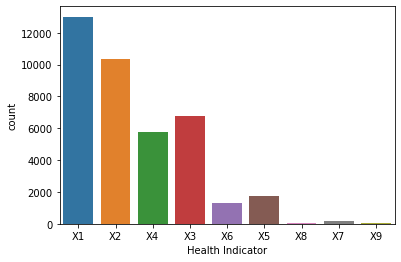

In [16]:
sns.countplot(train_df['Health Indicator'])

In [17]:
most_freq = train_df['Health Indicator'].mode()[0]
print(most_freq)

train_df['Health Indicator'] = train_df['Health Indicator'].fillna(most_freq)
test_df['Health Indicator'] = test_df['Health Indicator'].fillna(most_freq)

X1


In [18]:
train_df['Holding_Policy_Duration'].unique()

array(['14+', nan, '1.0', '3.0', '5.0', '9.0', '14.0', '7.0', '2.0',
       '11.0', '10.0', '8.0', '6.0', '4.0', '13.0', '12.0'], dtype=object)

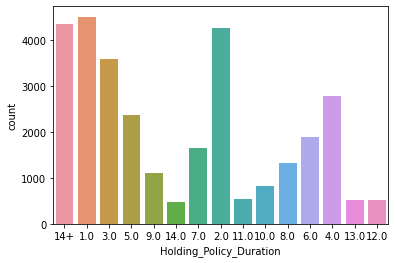

In [19]:
sns.countplot(train_df['Holding_Policy_Duration'])

In [20]:
# most_freq = train_df['Holding_Policy_Duration'].mode()[0]
most_freq = str(0.0)
print(most_freq)

train_df['Holding_Policy_Duration'] = train_df['Holding_Policy_Duration'].fillna(most_freq)
test_df['Holding_Policy_Duration'] = test_df['Holding_Policy_Duration'].fillna(most_freq)

0.0


In [21]:
train_df['Holding_Policy_Type'].unique()

array([ 3., nan,  1.,  4.,  2.])

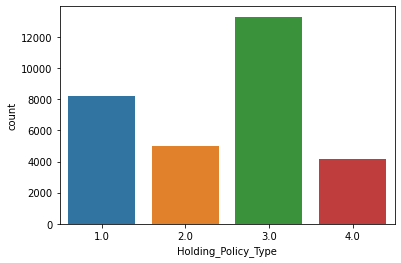

In [22]:
sns.countplot(train_df['Holding_Policy_Type'])

In [23]:
# most_freq = train_df['Holding_Policy_Type'].mode()[0]
most_freq = 'no_policies'
print(most_freq)

train_df['Holding_Policy_Type'] = train_df['Holding_Policy_Type'].fillna(most_freq)
test_df['Holding_Policy_Type'] = test_df['Holding_Policy_Type'].fillna(most_freq)

no_policies


In [24]:
train_df.columns

Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
       'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
       'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
       'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
      dtype='object')

In [25]:
train_df['Holding_Policy_Type'] = train_df['Holding_Policy_Type'].astype(str)
test_df['Holding_Policy_Type'] = test_df['Holding_Policy_Type'].astype(str)

train_df['Reco_Policy_Cat'] = train_df['Reco_Policy_Cat'].astype(str)
test_df['Reco_Policy_Cat'] = test_df['Reco_Policy_Cat'].astype(str)

train_df['Region_Code'] = train_df['Region_Code'].astype(str)
test_df['Region_Code'] = test_df['Region_Code'].astype(str)

In [26]:
cols_to_remove = ['ID']
target = 'Response'

_X = train_df.drop(cols_to_remove + [target], axis=1)
y = train_df[target]
_XTEST = test_df.drop(cols_to_remove , axis=1)

In [27]:
_X.shape, _XTEST.shape

((50882, 12), (21805, 12))

In [28]:
X_all = pd.concat([_X, _XTEST]).reset_index(drop=True)
X_all.shape

(72687, 12)

# Label Encoding

In [29]:
cat_columns = []
for col in X_all.select_dtypes('object').columns:
    print(col)
    cat_columns.append(col)
    le = LabelEncoder()
    X_all[col] = le.fit_transform(X_all[col])

City_Code
Region_Code
Accomodation_Type
Reco_Insurance_Type
Is_Spouse
Health Indicator
Holding_Policy_Duration
Holding_Policy_Type
Reco_Policy_Cat


In [30]:
X_all.shape

(72687, 12)

In [31]:
X_all.head()

,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,22,2137,1,0,36,36,0,0,6,2,14,11628.0
1,31,117,0,1,75,22,0,1,0,4,14,30510.0
2,31,2664,0,0,32,32,0,0,1,0,10,7450.0
3,16,3322,0,1,52,48,0,0,6,2,10,17780.0
4,34,1151,1,0,44,44,0,1,9,0,7,10404.0


In [32]:
X = X_all[:len(y)]
XTEST = X_all[len(y):]
X.shape, XTEST.shape

((50882, 12), (21805, 12))

In [33]:
X.columns

Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator',
       'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat',
       'Reco_Policy_Premium'],
      dtype='object')

# Train & Validation data split

In [34]:
X_train , X_valid, y_train, y_valid = train_test_split(X,y, 
                                                       test_size=0.2, 
                                                       random_state=SEED, 
                                                       stratify=y)

# LGBMClassifier

In [35]:
NUM_OF_BOOST_ROUND = 10000
EARLY_STOPPING = 300

In [36]:
cat_features_index = [i for i,col in enumerate(X.columns) if col in cat_columns]
cat_features_index

[0, 1, 2, 3, 6, 7, 8, 9, 10]

In [37]:
X.columns

Index(['City_Code', 'Region_Code', 'Accomodation_Type', 'Reco_Insurance_Type',
       'Upper_Age', 'Lower_Age', 'Is_Spouse', 'Health Indicator',
       'Holding_Policy_Duration', 'Holding_Policy_Type', 'Reco_Policy_Cat',
       'Reco_Policy_Premium'],
      dtype='object')

In [38]:
params = {
    'cat_features' : cat_features_index,
    'metric': 'auc',
    'seed': SEED,
    'n_estimators': NUM_OF_BOOST_ROUND
}

In [39]:

clf = lgb.LGBMClassifier(**params)

In [40]:
clf.fit(X_train, y_train, eval_set=(X_valid, y_valid), early_stopping_rounds=100, verbose=-1)

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[83]	valid_0's auc: 0.672733


LGBMClassifier(boosting_type='gbdt', cat_features=[0, 1, 2, 3, 6, 7, 8, 9, 10],
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.1, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=10000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, seed=2021,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [41]:
ypred_lgb = clf.predict_proba(X_valid)[:,1]

In [42]:

roc_auc_score(y_valid, ypred_lgb)

0.6727334668511139

In [43]:
ytest = clf.predict_proba(XTEST)[:,1]

In [44]:
sub_df.Response = ytest

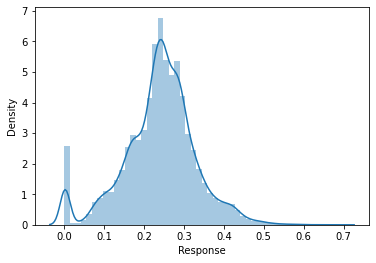

In [45]:
sns.distplot(sub_df.Response)

# CatBoostClassifier

In [46]:
params = {
    'cat_features': cat_features_index,
    'eval_metric': 'AUC',
    'random_seed': SEED,
    'n_estimators': NUM_OF_BOOST_ROUND,
}

In [47]:
bst = CatBoostClassifier(**params, early_stopping_rounds=EARLY_STOPPING)
_ = bst.fit(X_train, y_train, eval_set=(X_valid,y_valid), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [48]:
ypred_cat = bst.predict_proba(X_valid)[:,1]

In [49]:
roc_auc_score(y_valid, ypred_cat)

0.8076720841426723

In [50]:
f_importance_df = pd.DataFrame(bst.get_feature_importance(), columns=['importance'], index=X_valid.columns)
f_importance_df = f_importance_df.sort_values(by='importance', ascending=False)

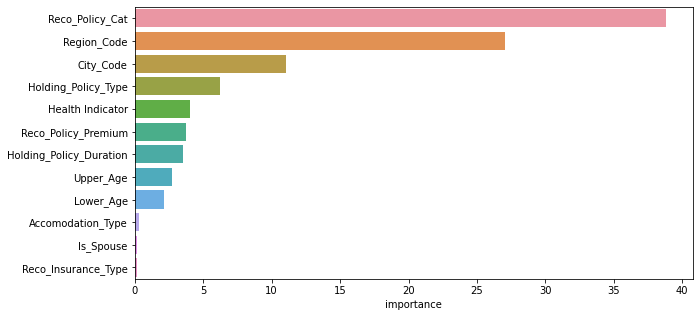

In [51]:

plt.figure(figsize=(10,5))
sns.barplot(x=f_importance_df.importance[:500], y=f_importance_df.index[:500]);

In [52]:
ypred_test = bst.predict_proba(XTEST)[:,1]

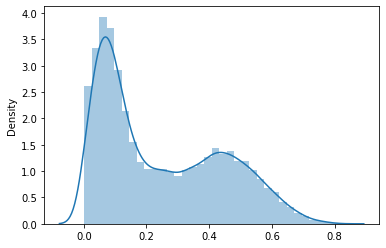

In [53]:
sns.distplot(ypred_test)

In [54]:
sub_df['Response'] = ypred_test

In [55]:
sub_df.head()

,ID,Response
0,50883,0.066341
1,50884,0.112245
2,50885,0.476900
3,50886,0.090483
4,50887,0.065597


In [56]:
sub_df.to_csv('catboost_submission.csv', index=False)

In [57]:
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')

# ROC comparision

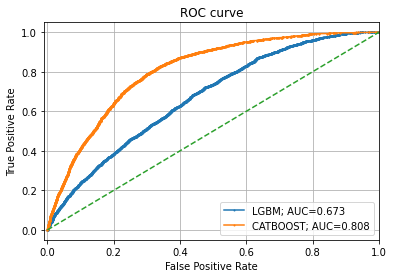

In [58]:
plot_roc(
    [y_valid]*2,
    [ypred_lgb, ypred_cat],
    ['LGBM', 'CATBOOST']
)